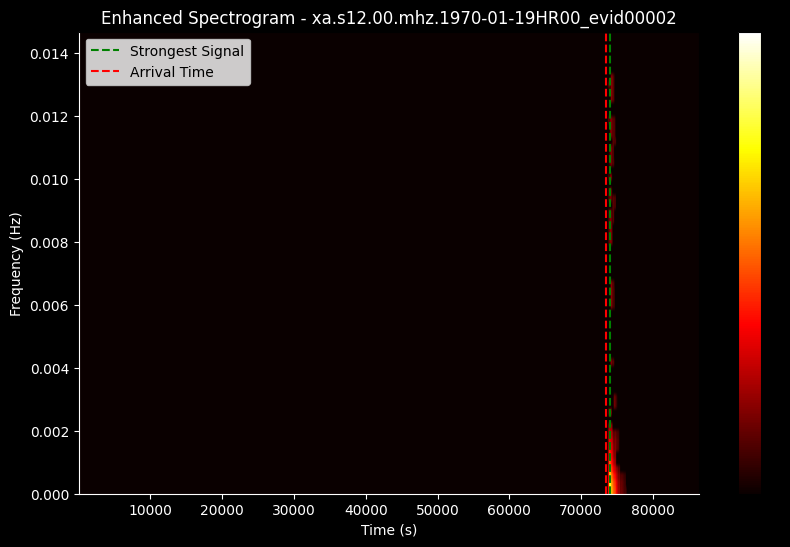

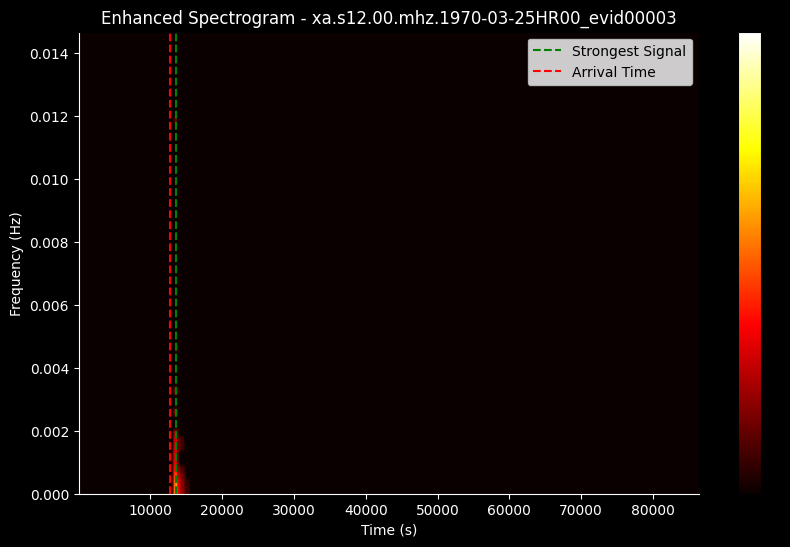

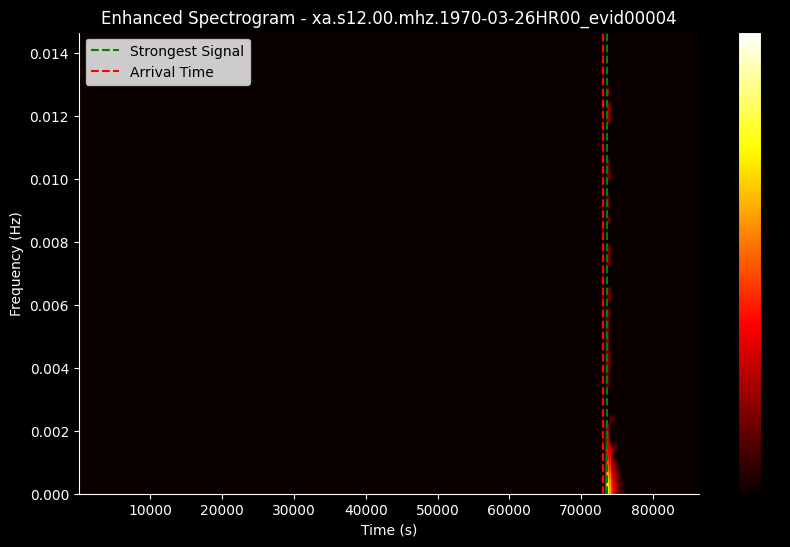

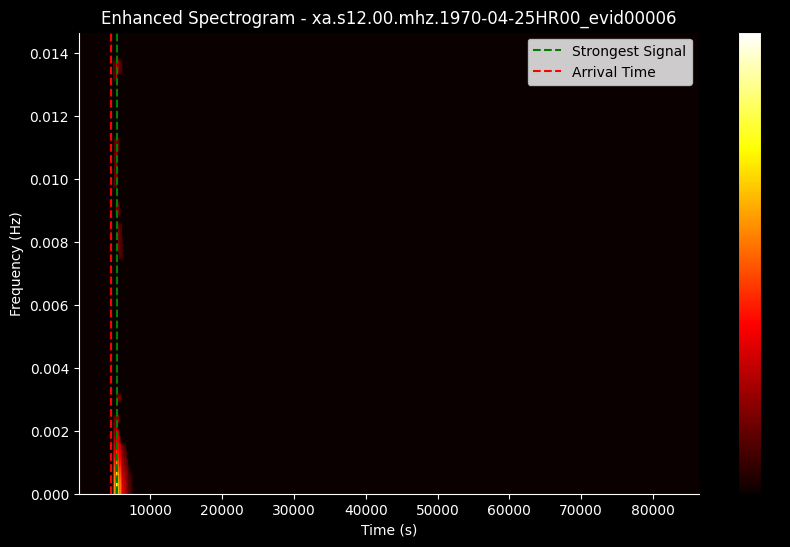

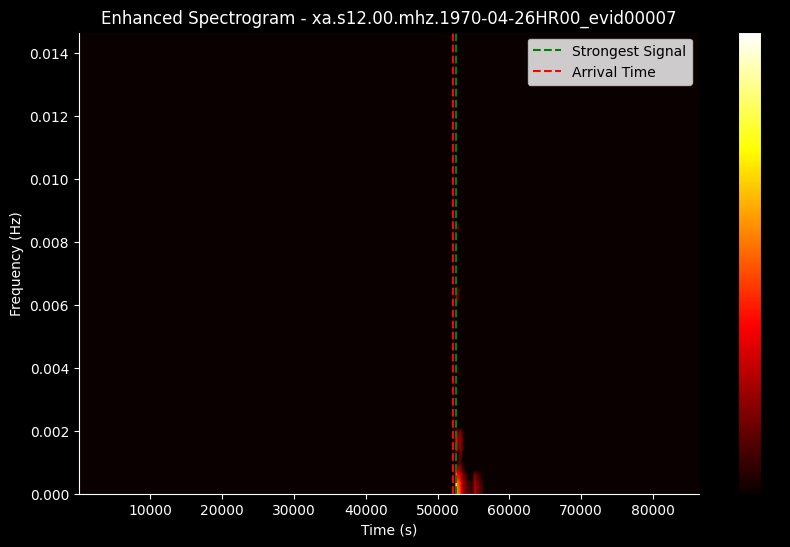

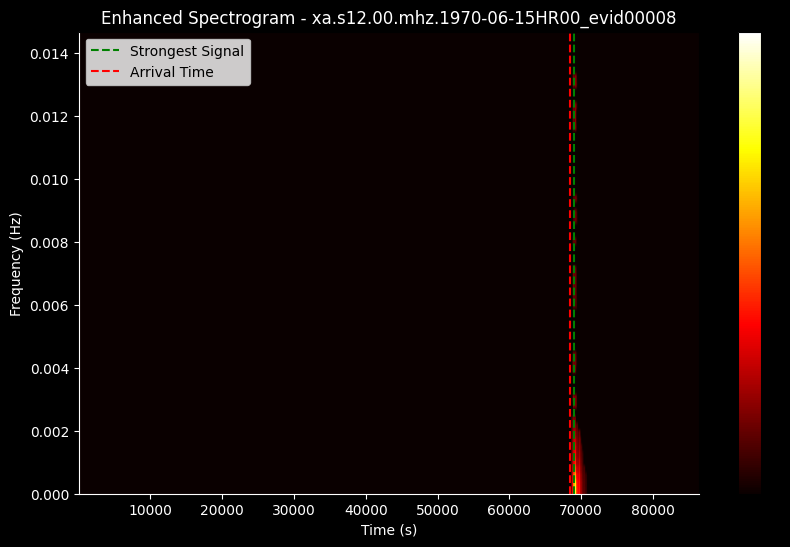

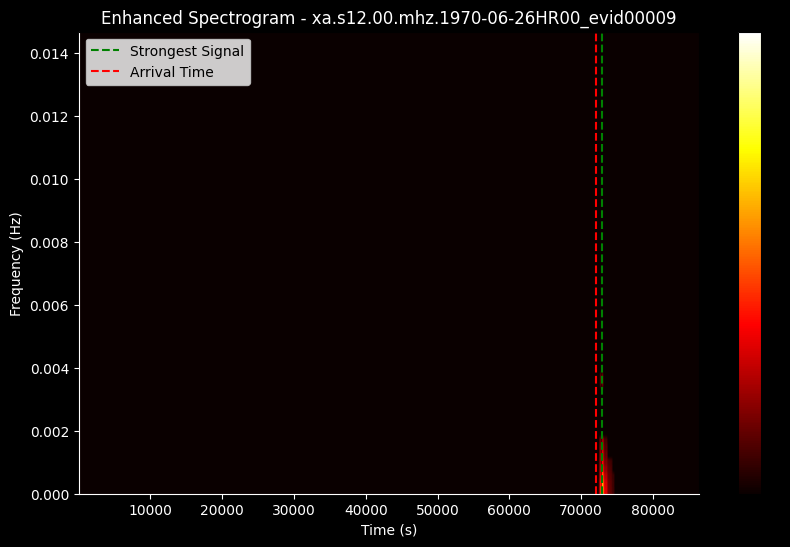

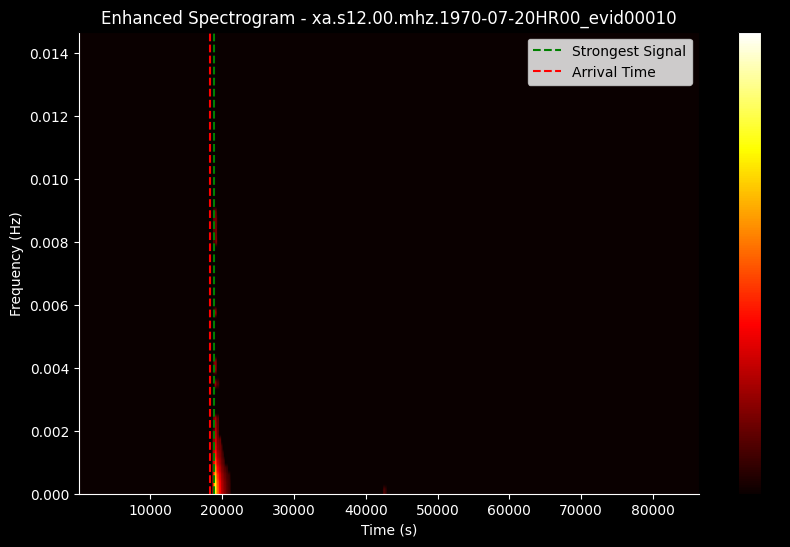

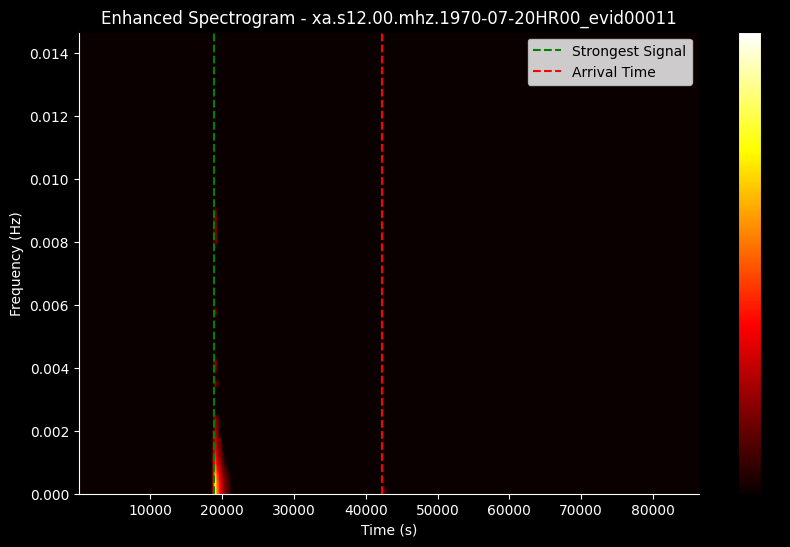

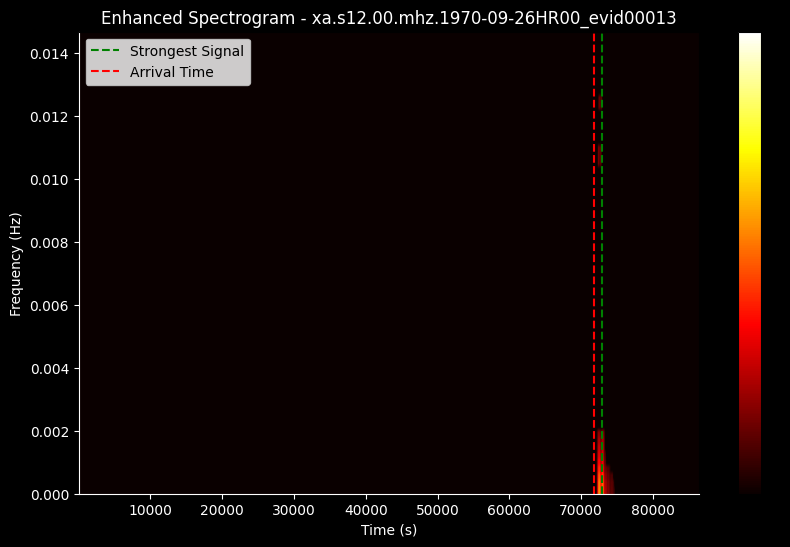

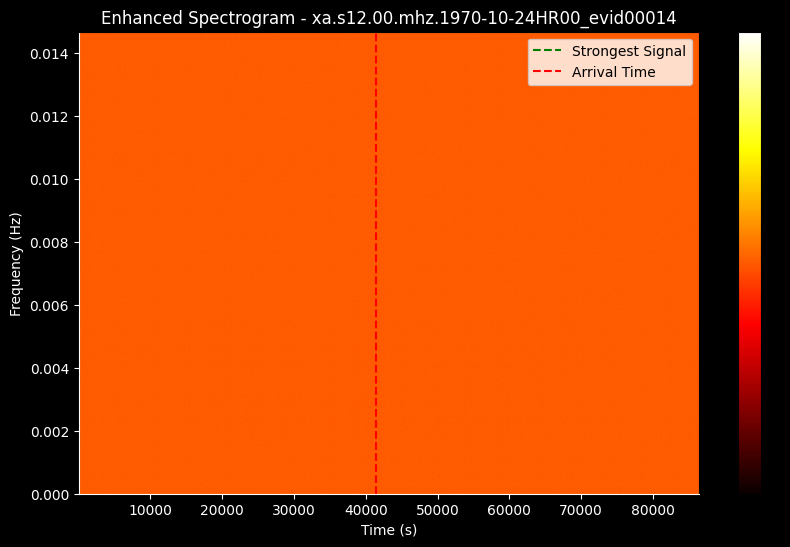

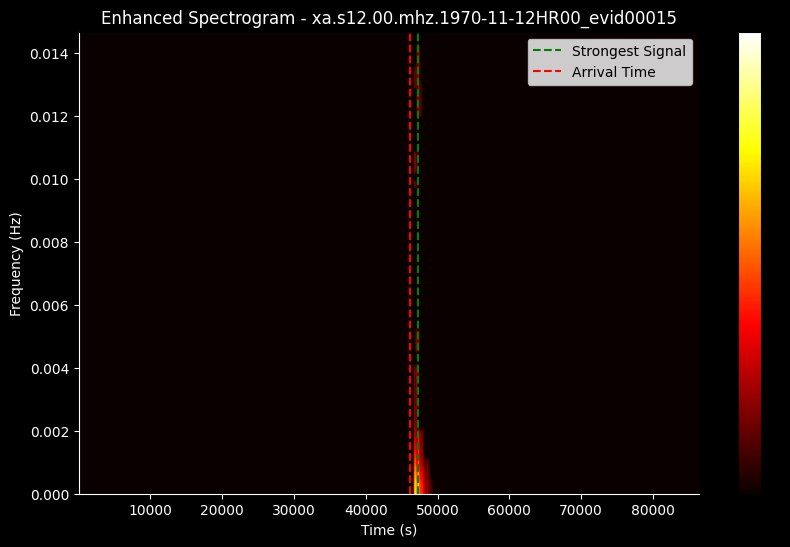

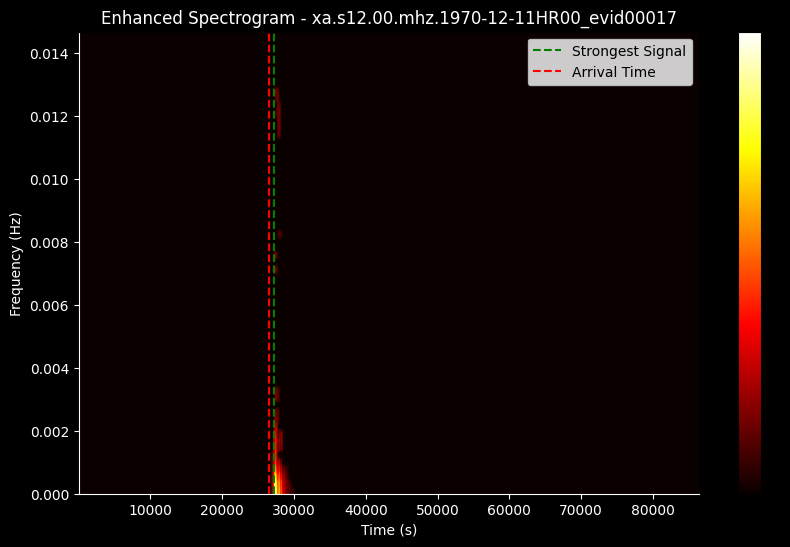

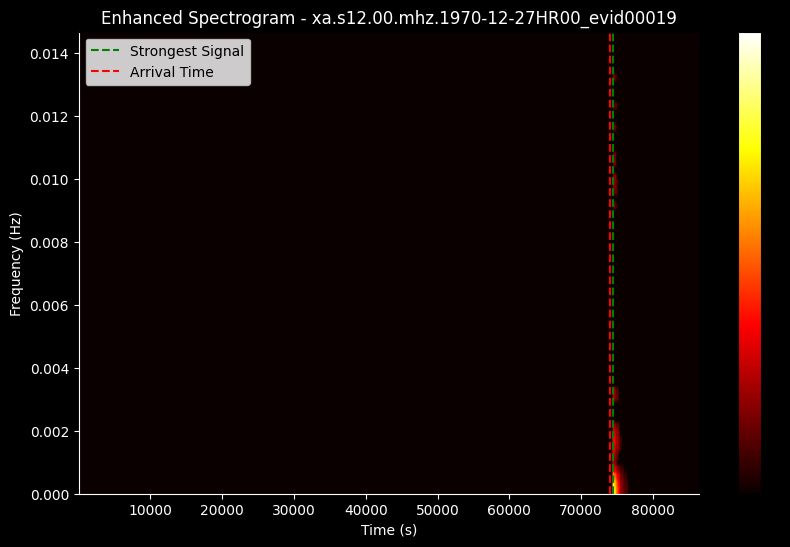

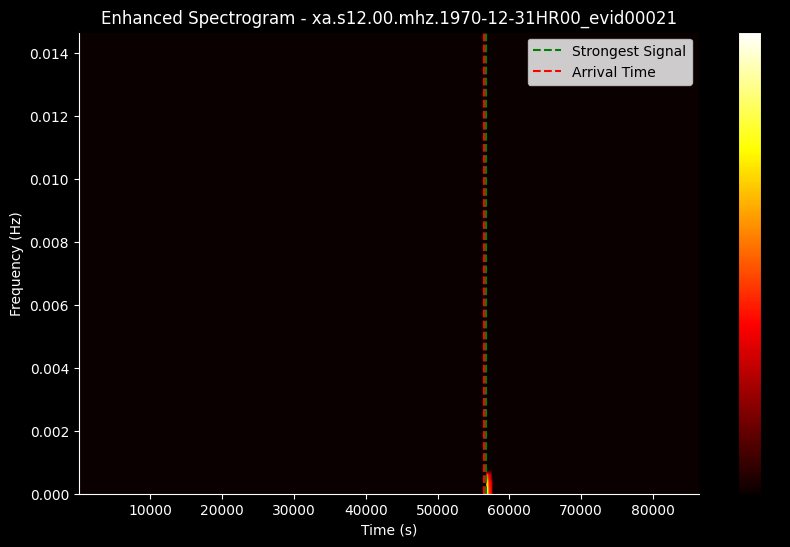

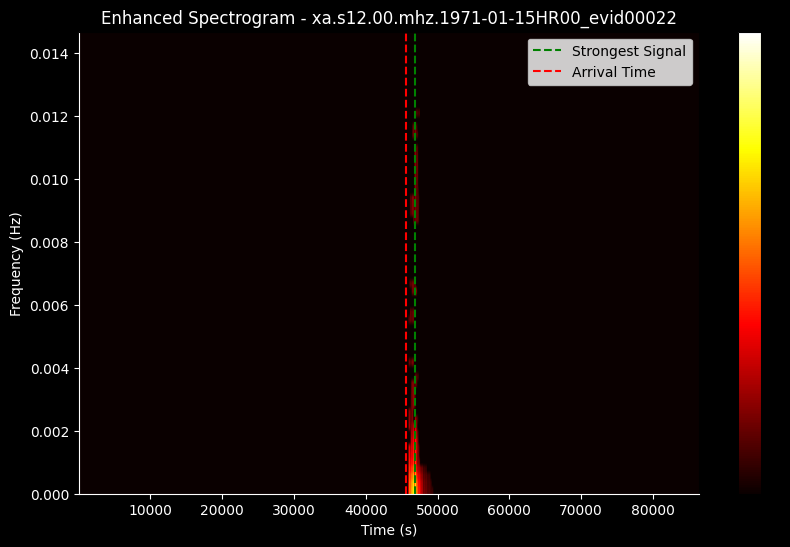

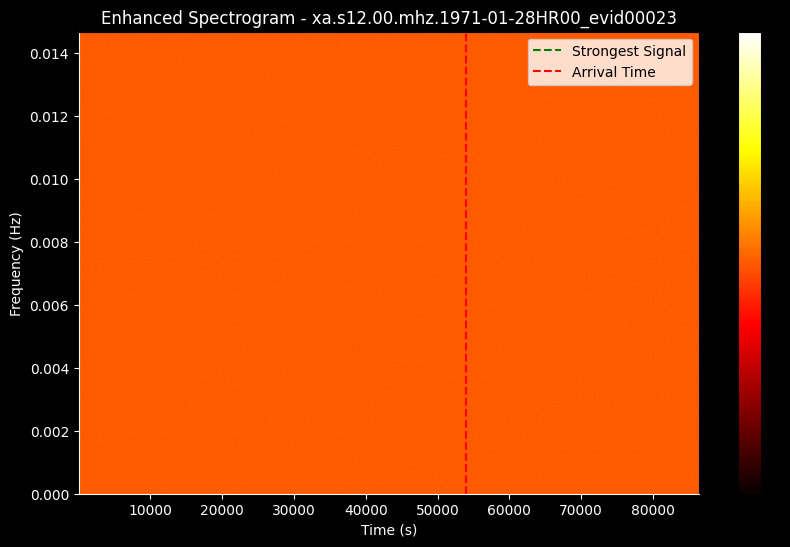

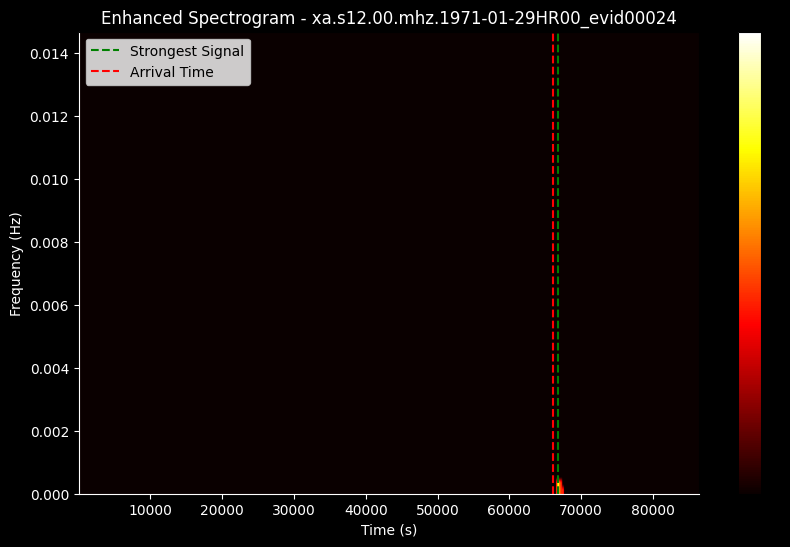

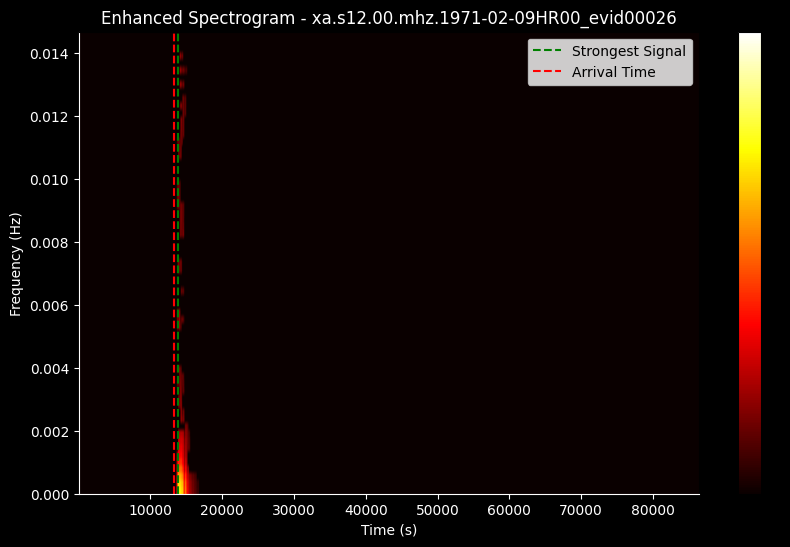

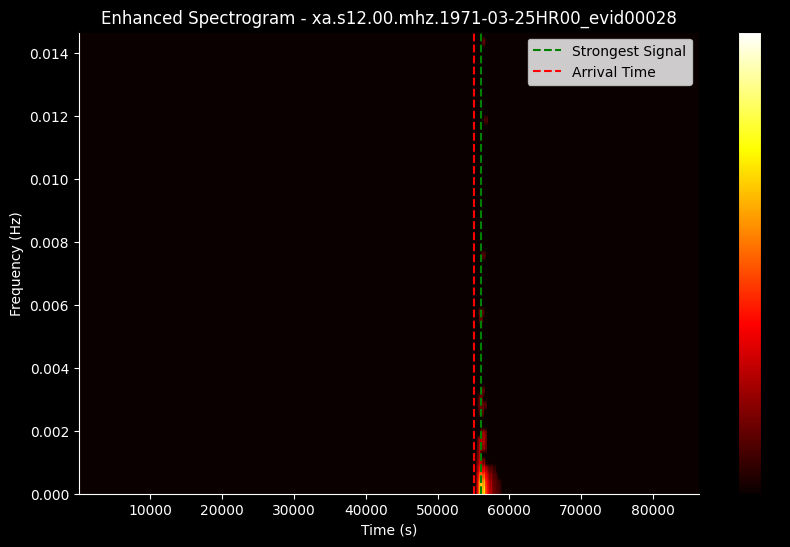

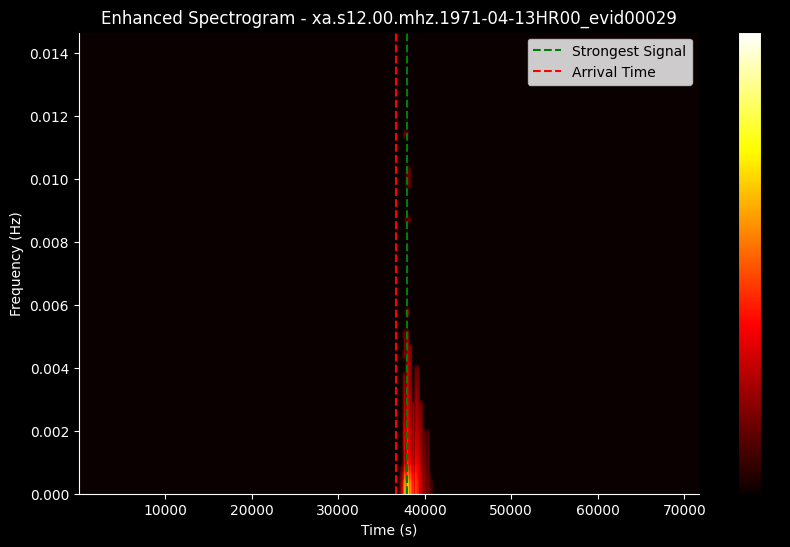

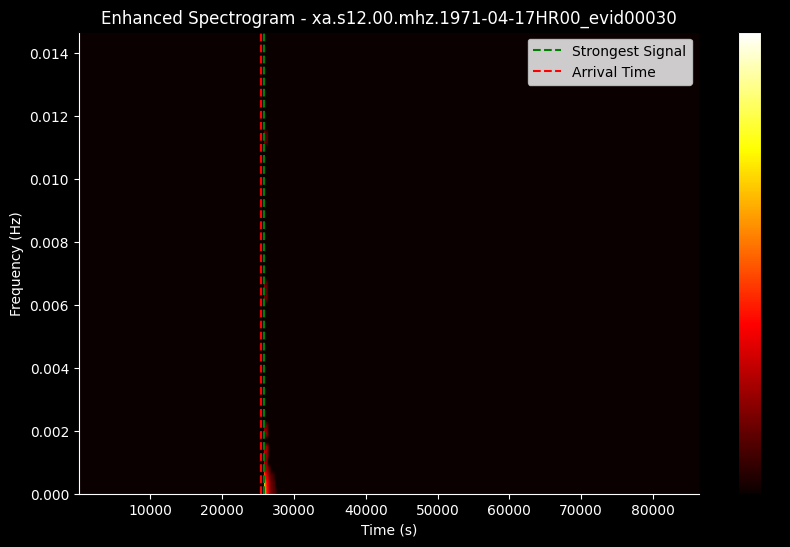

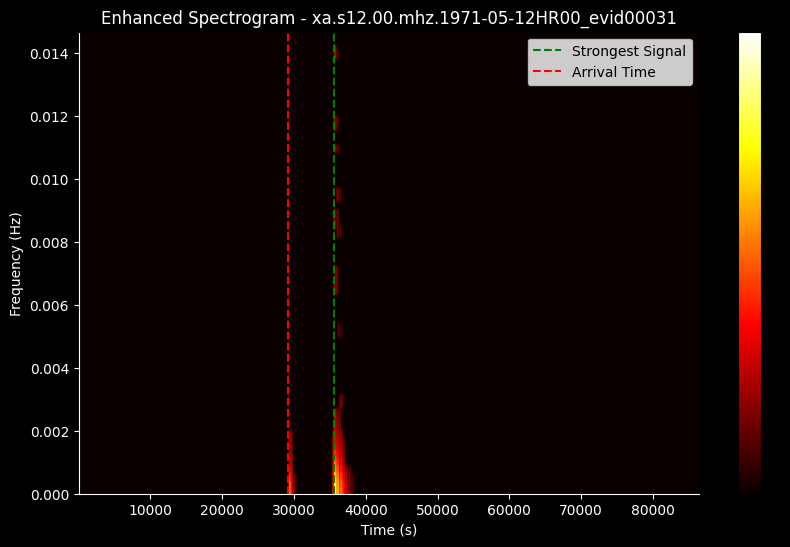

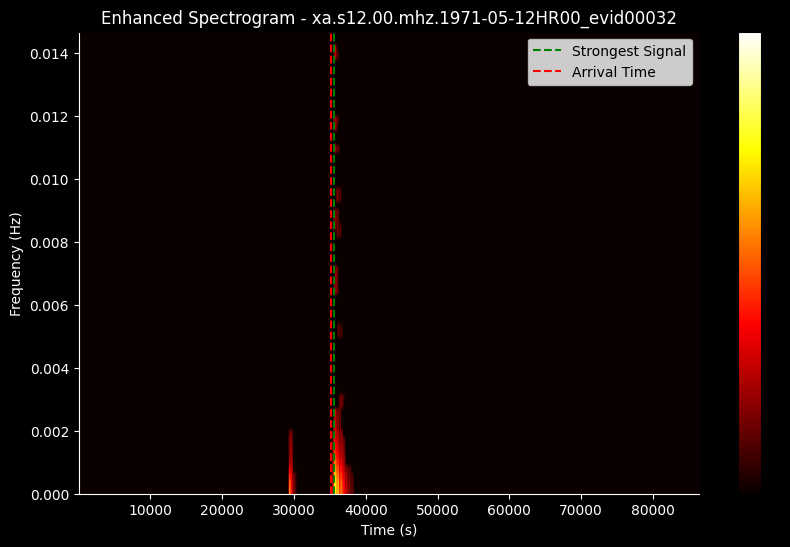

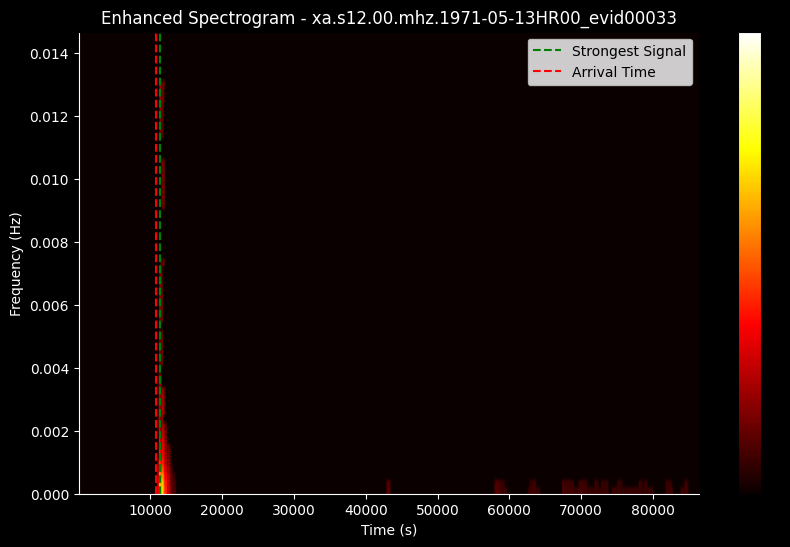

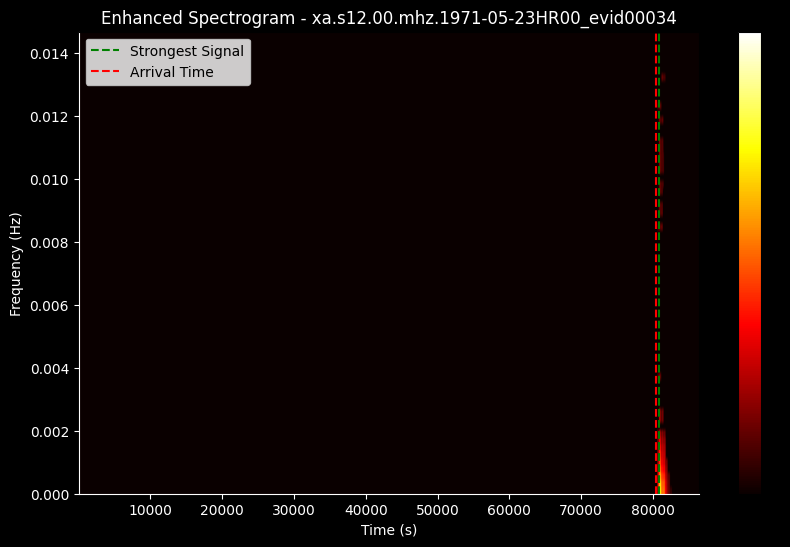

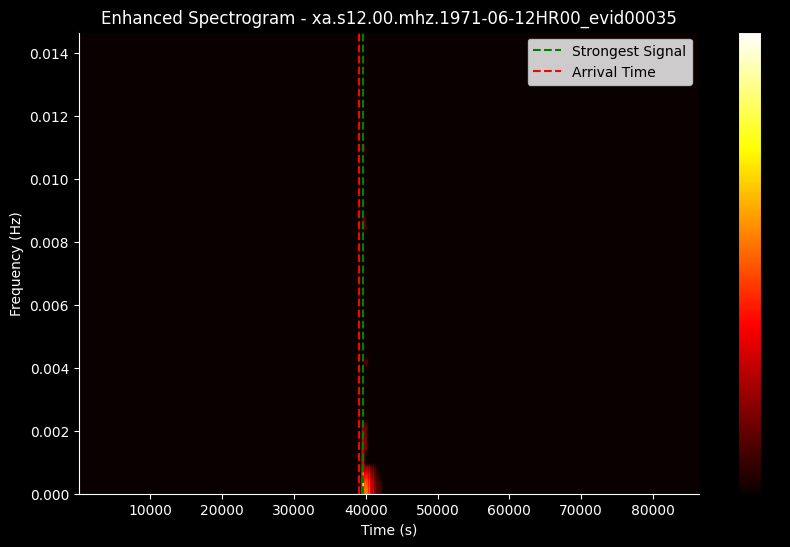

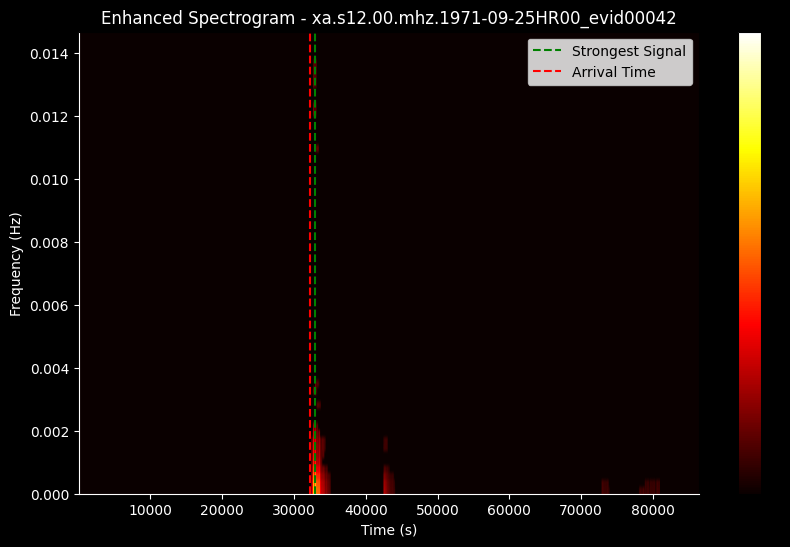

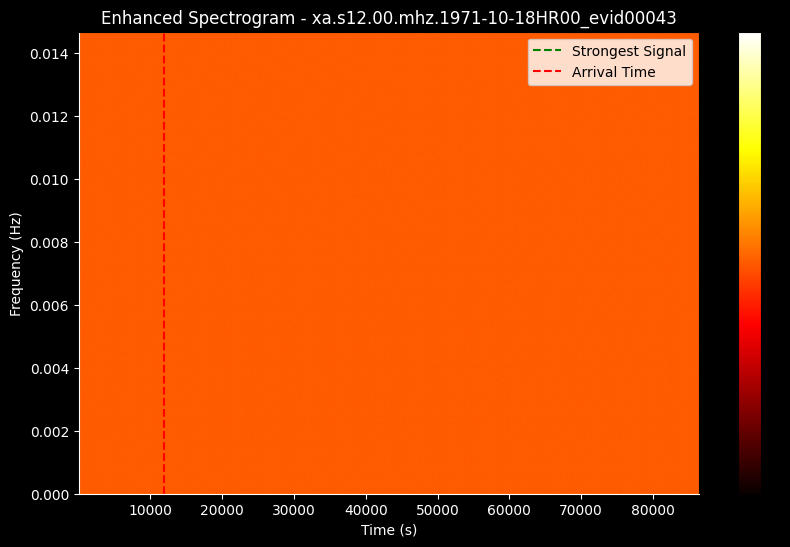

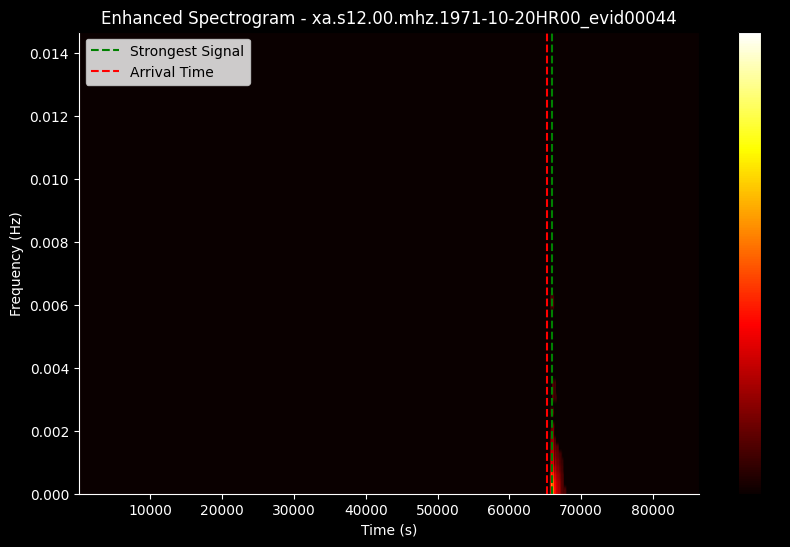

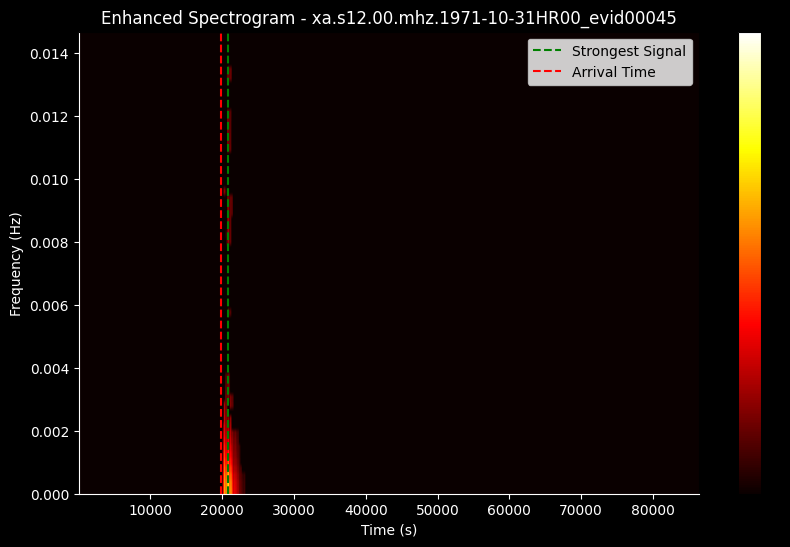

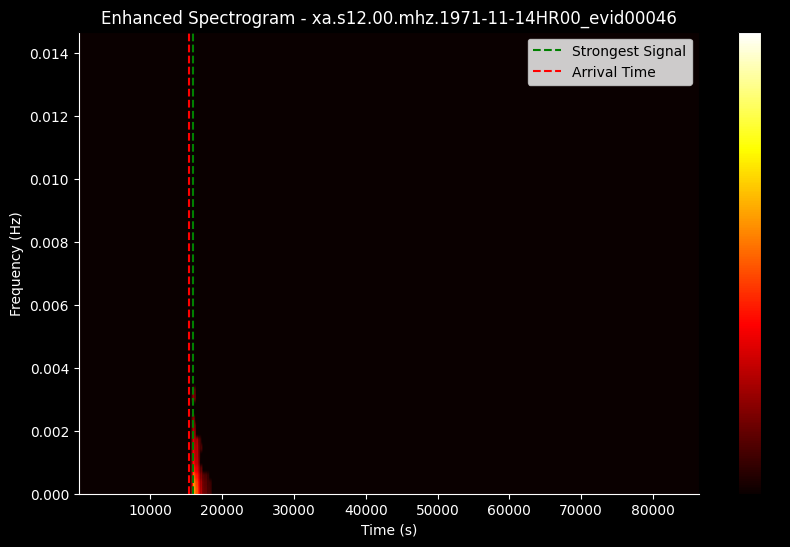

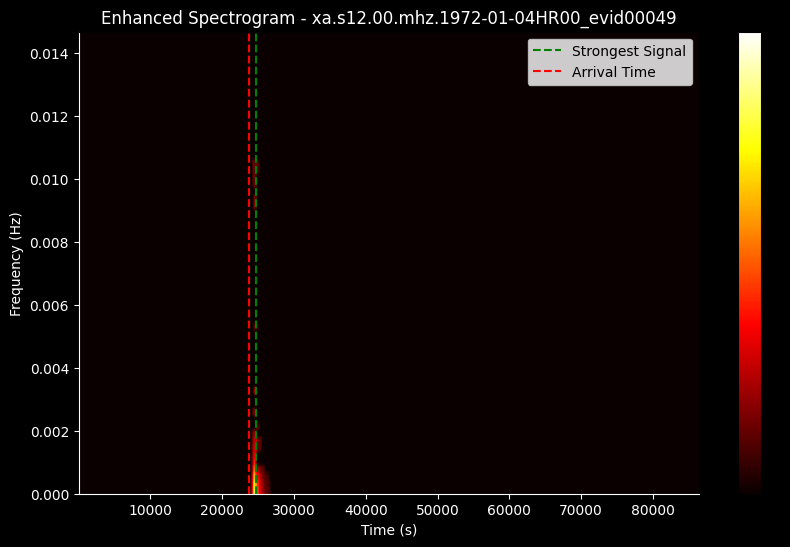

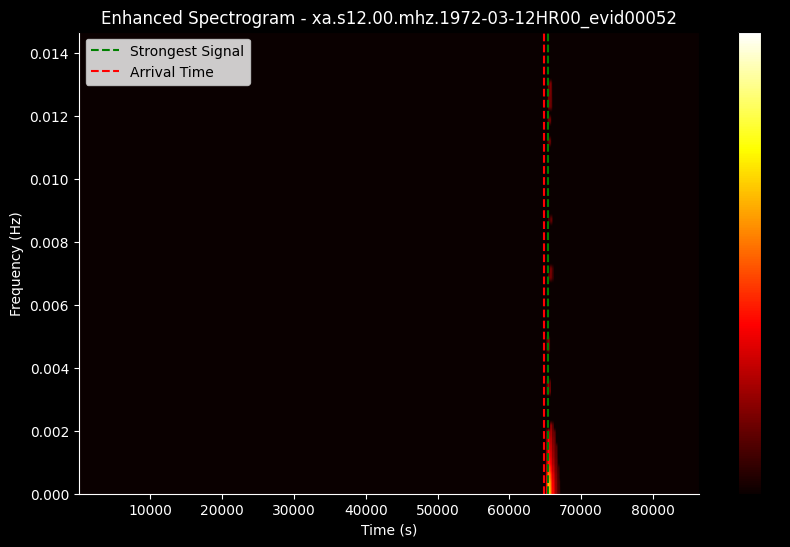

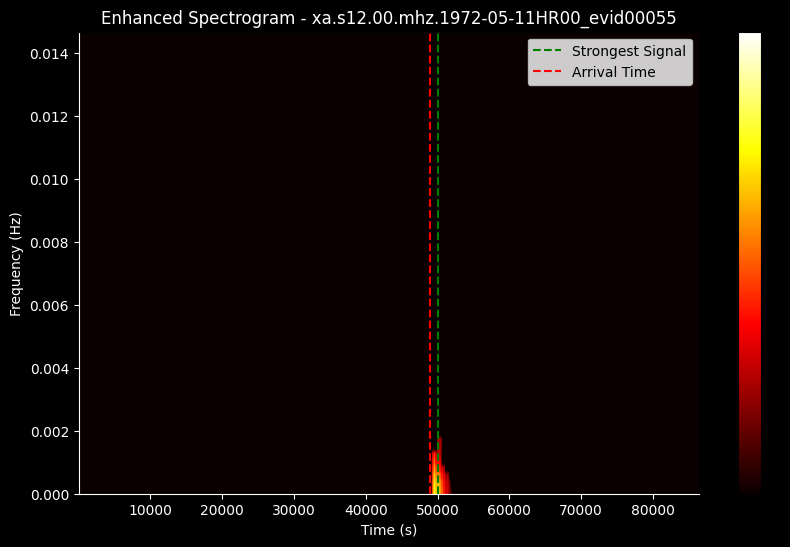

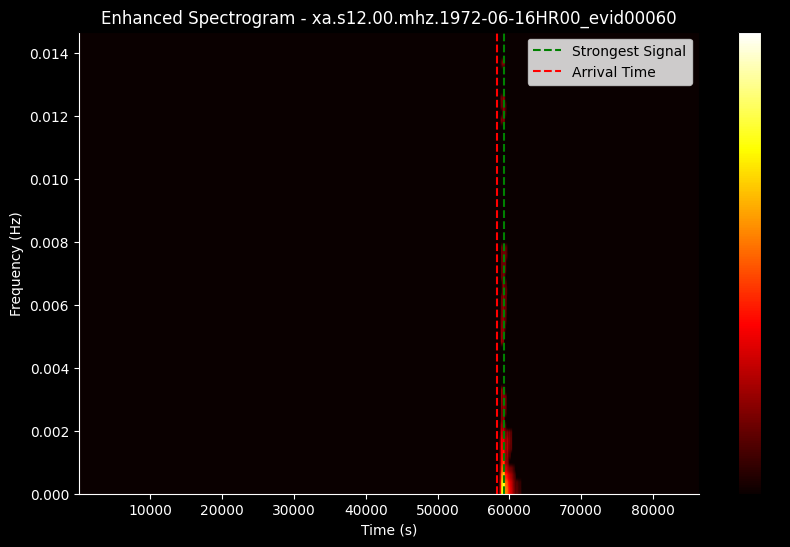

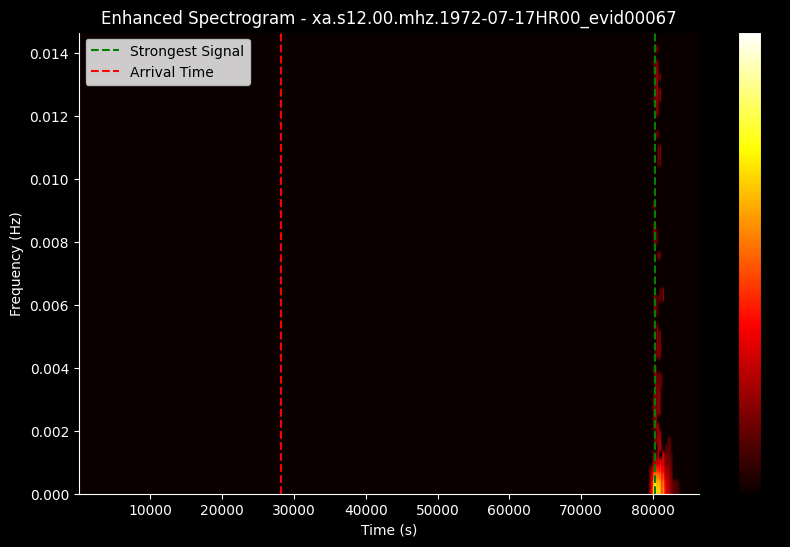

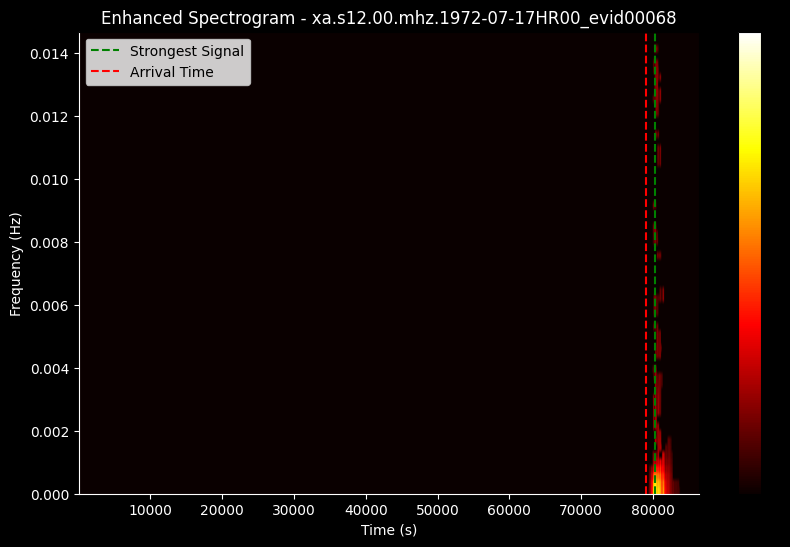

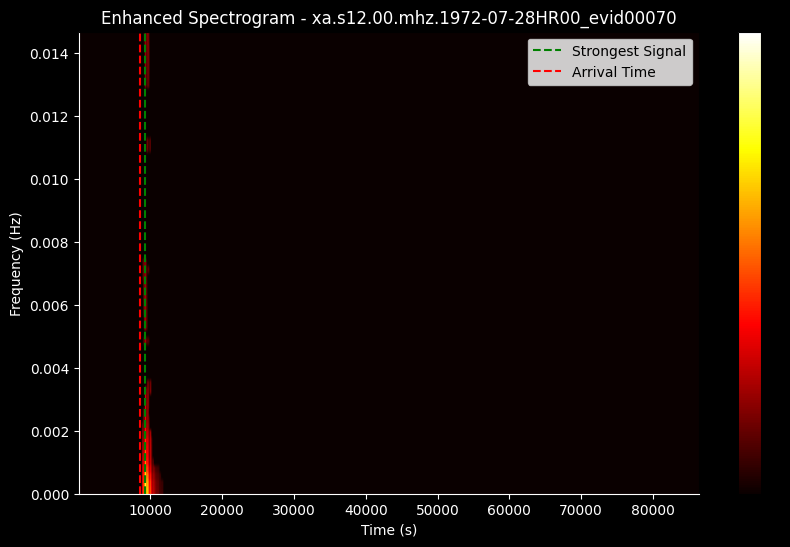

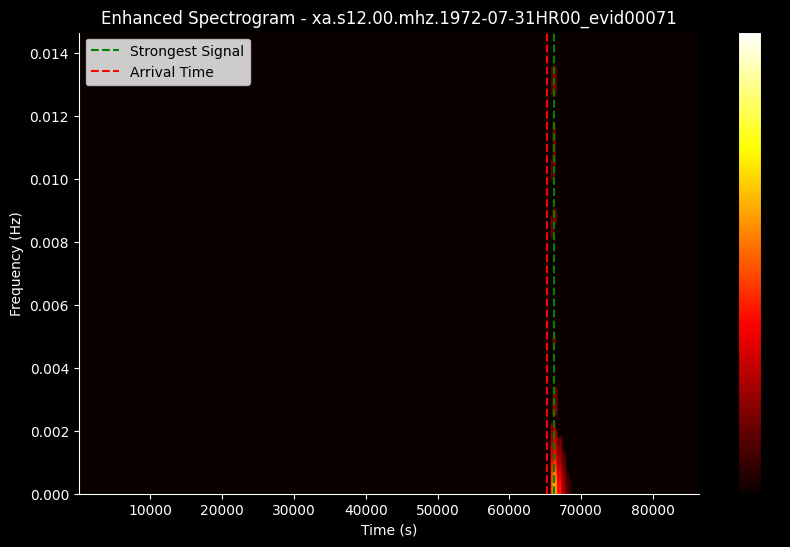

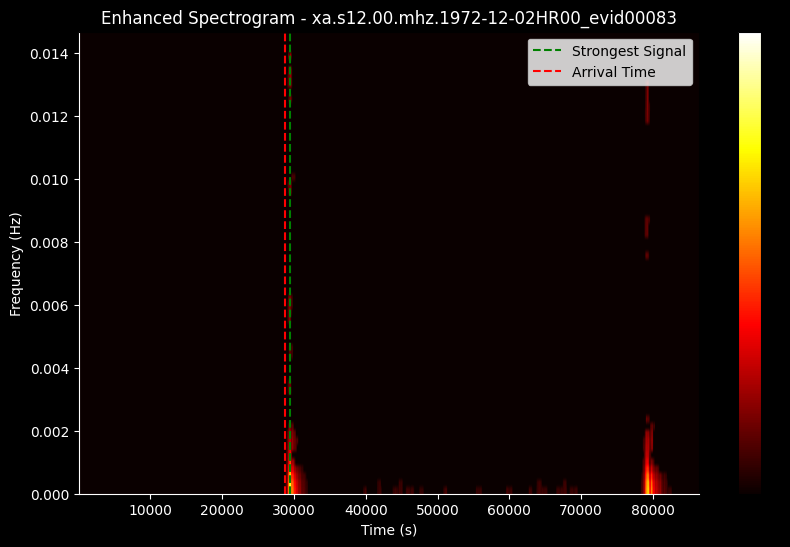

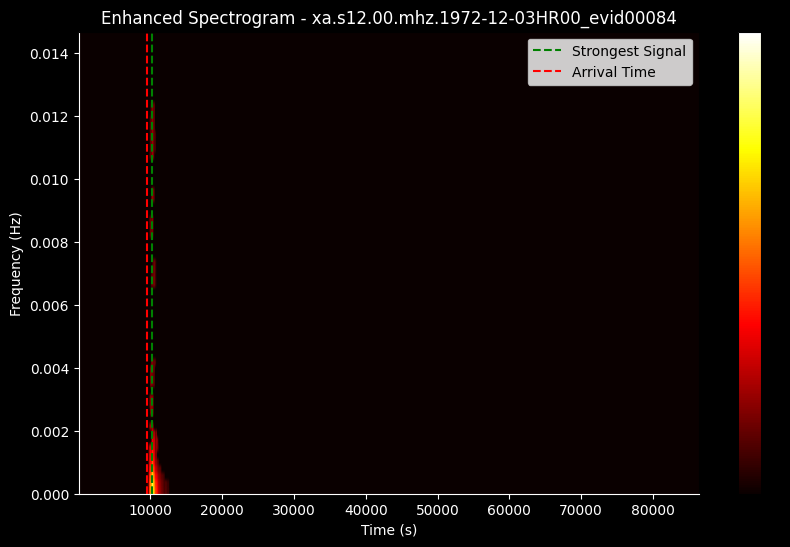

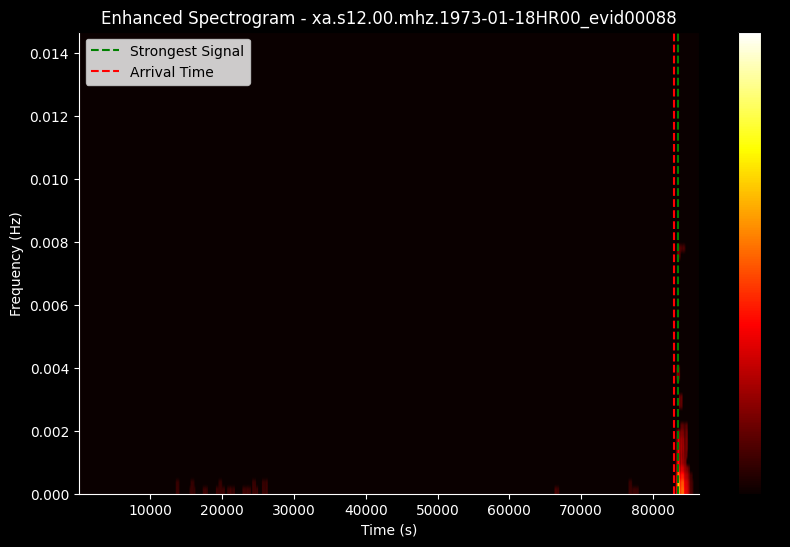

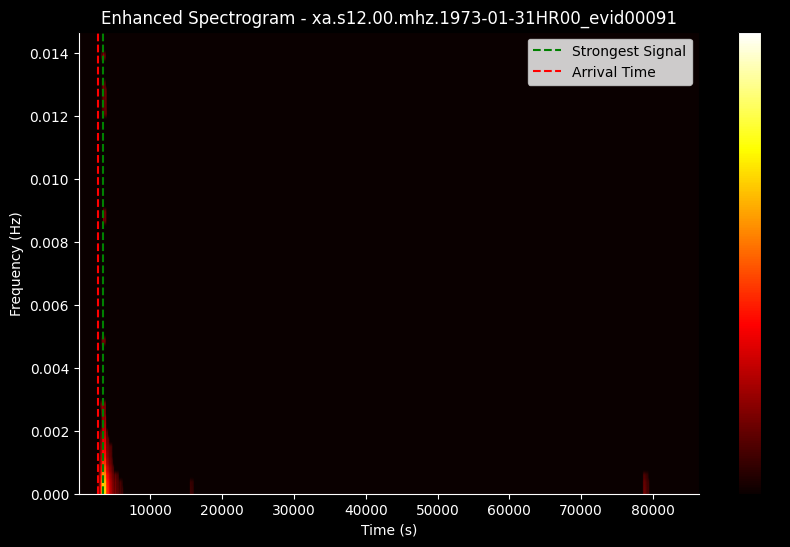

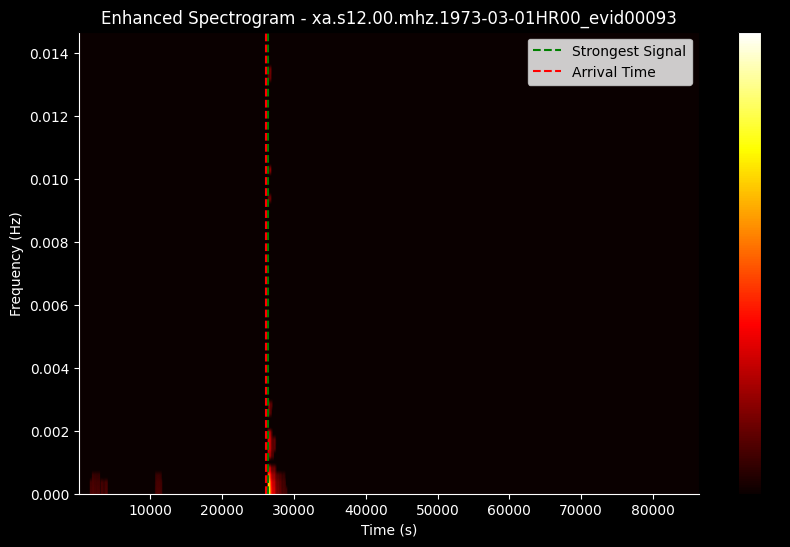

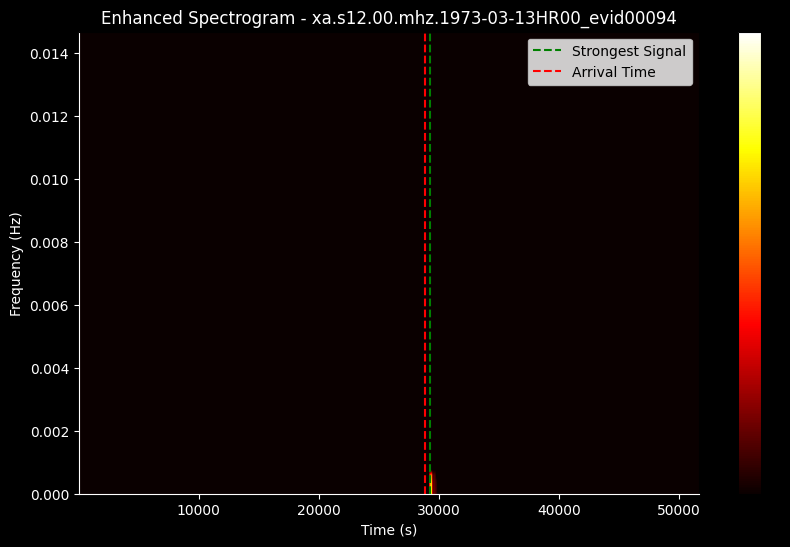

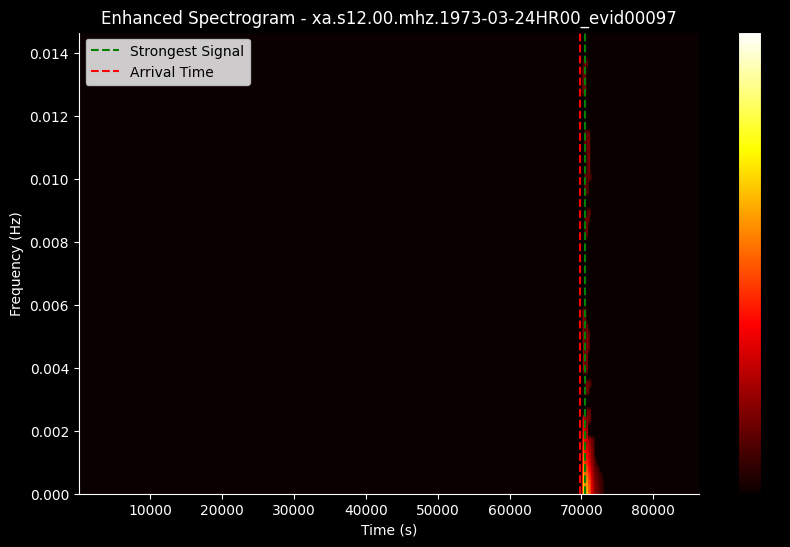

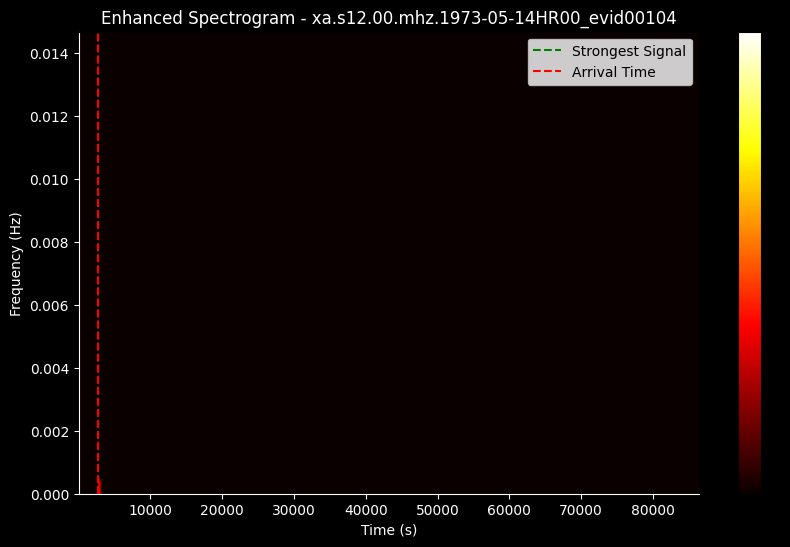

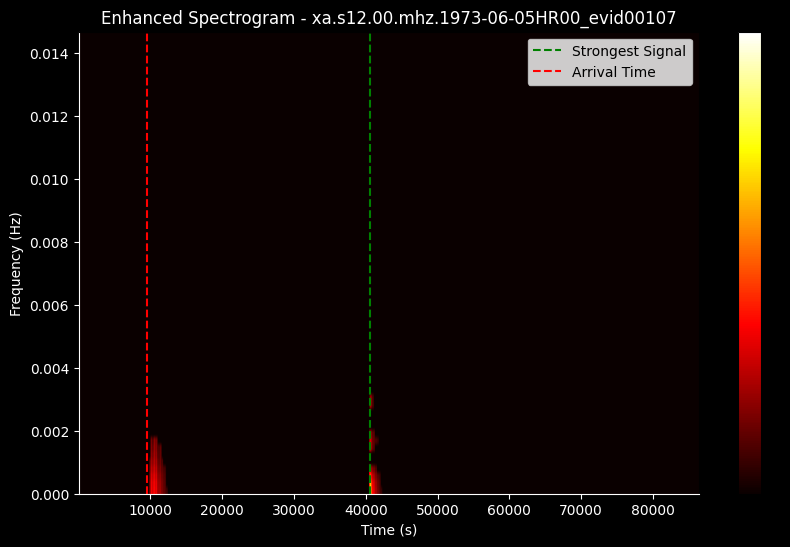

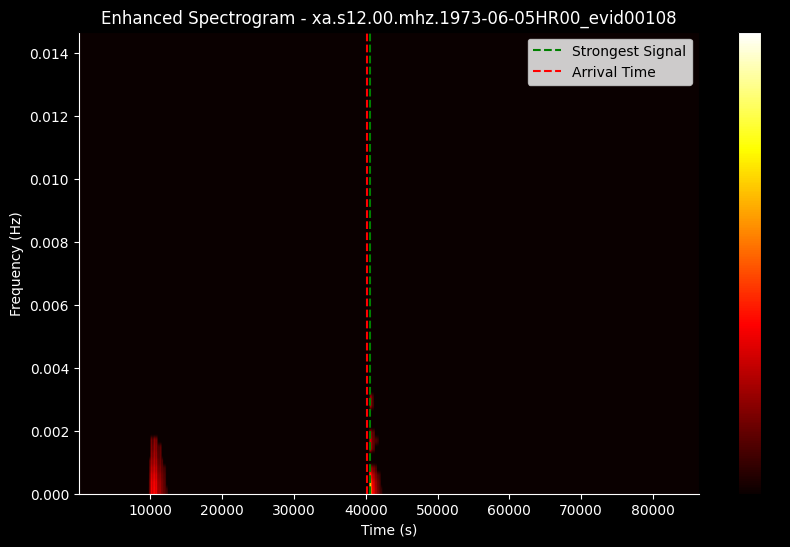

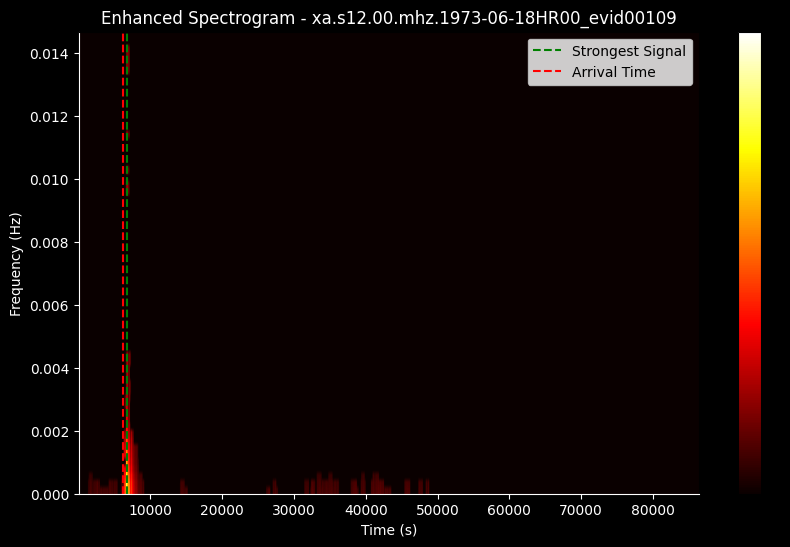

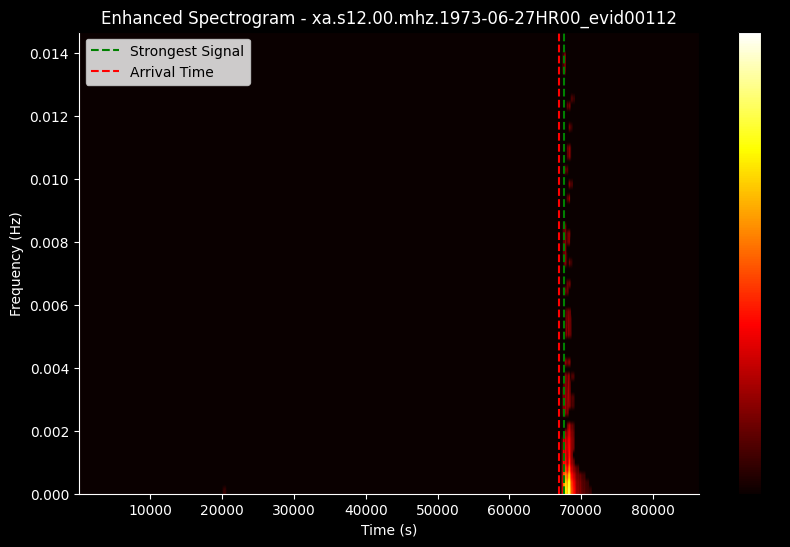

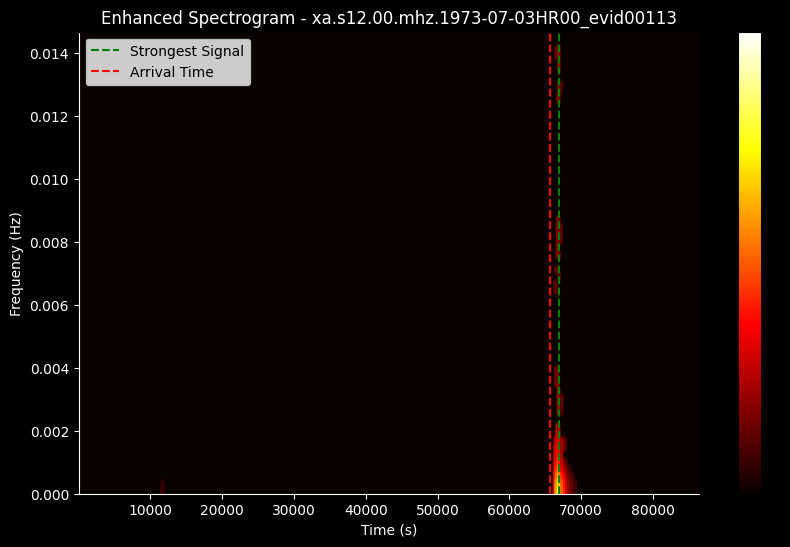

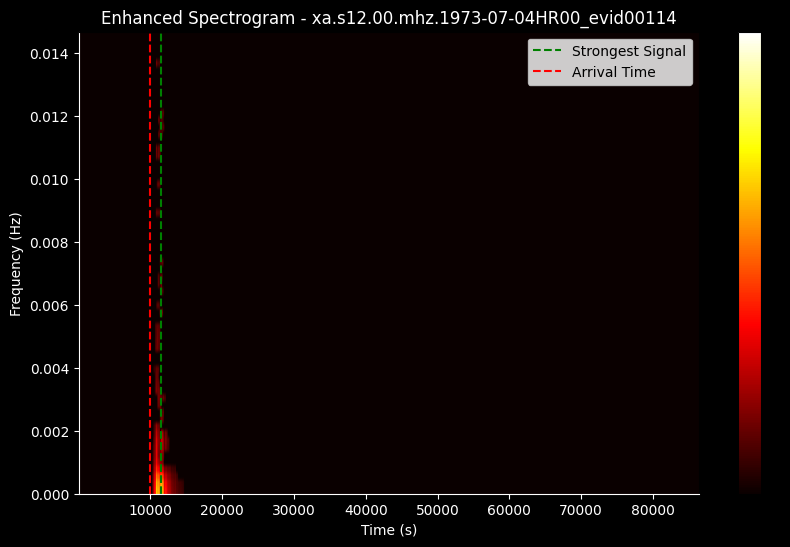

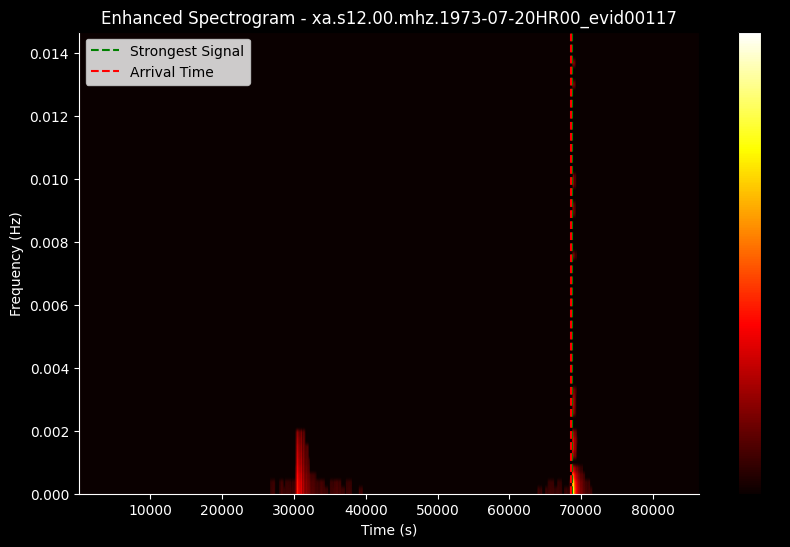

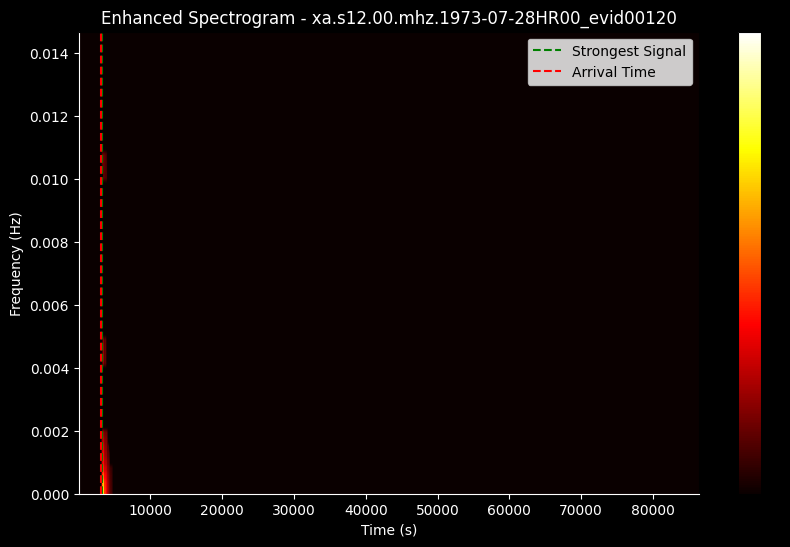

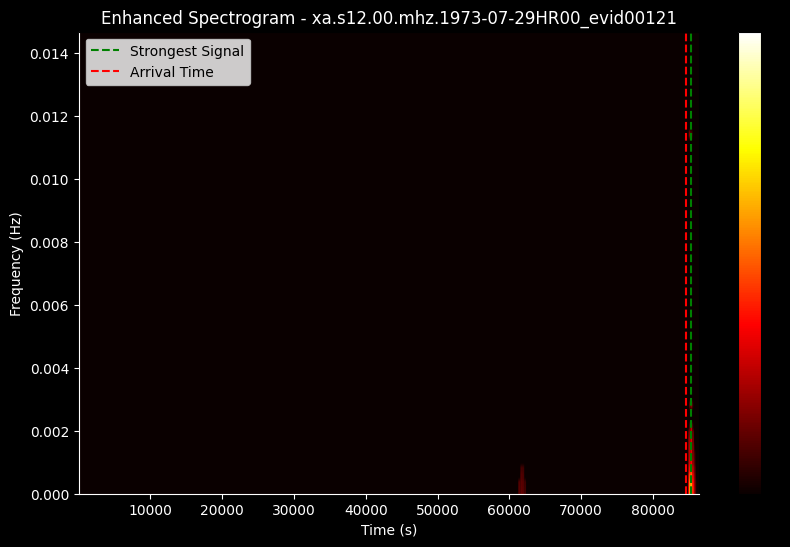

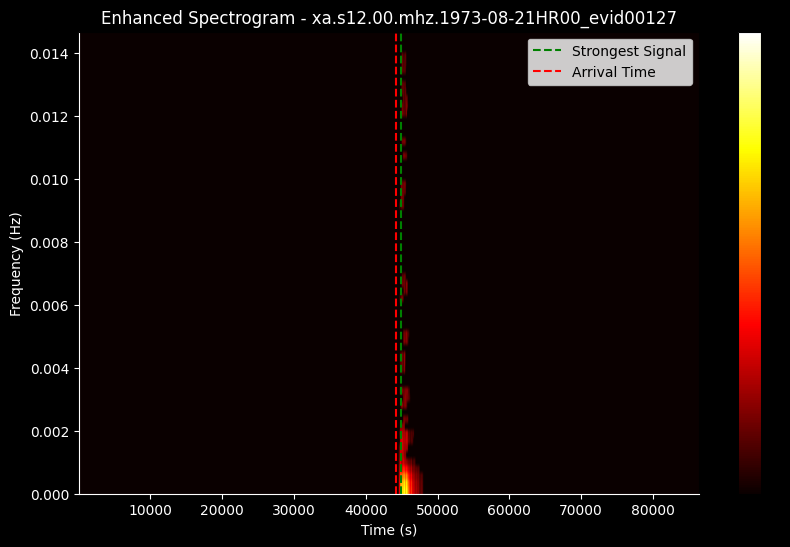

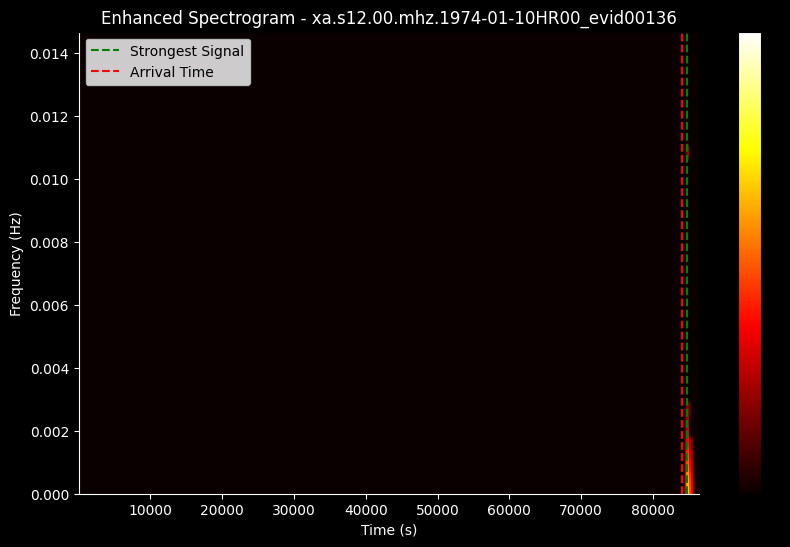

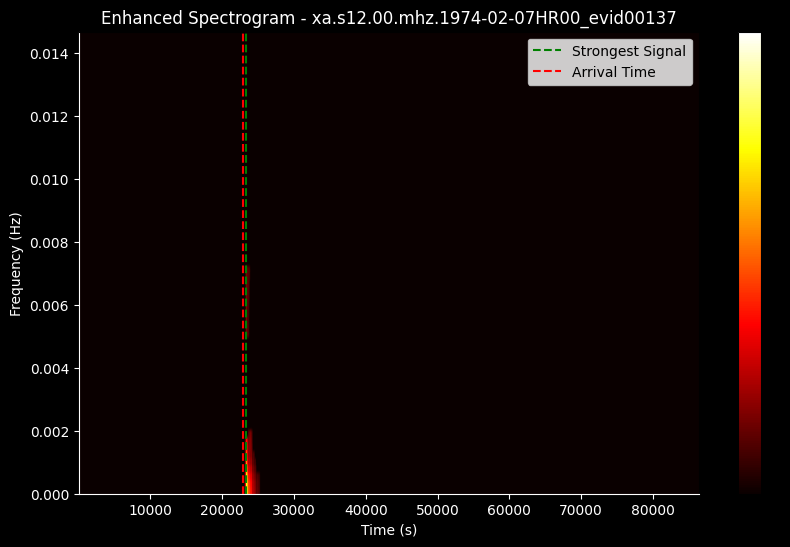

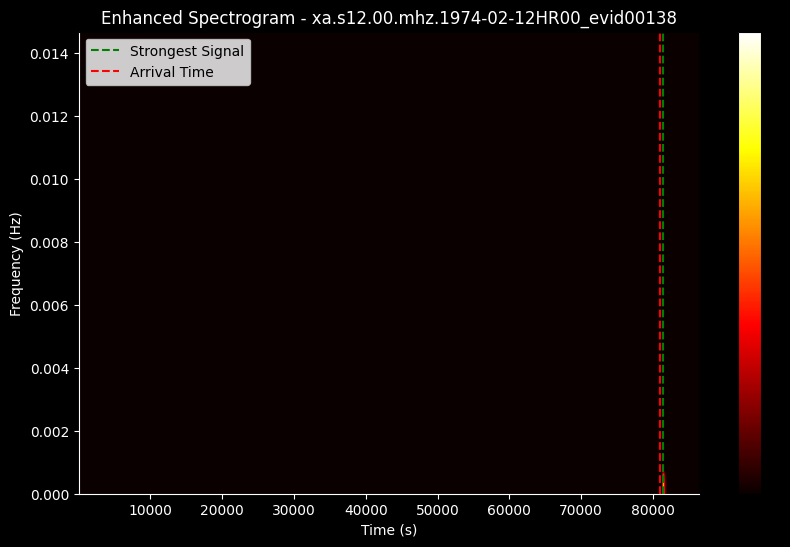

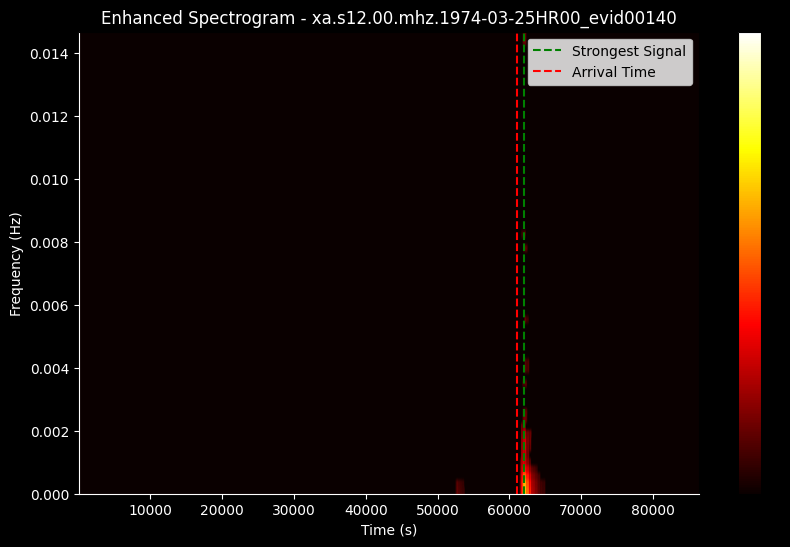

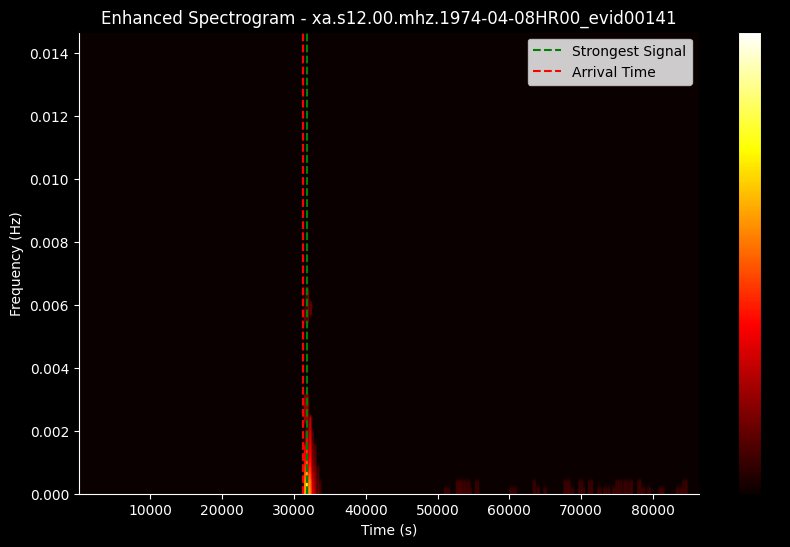

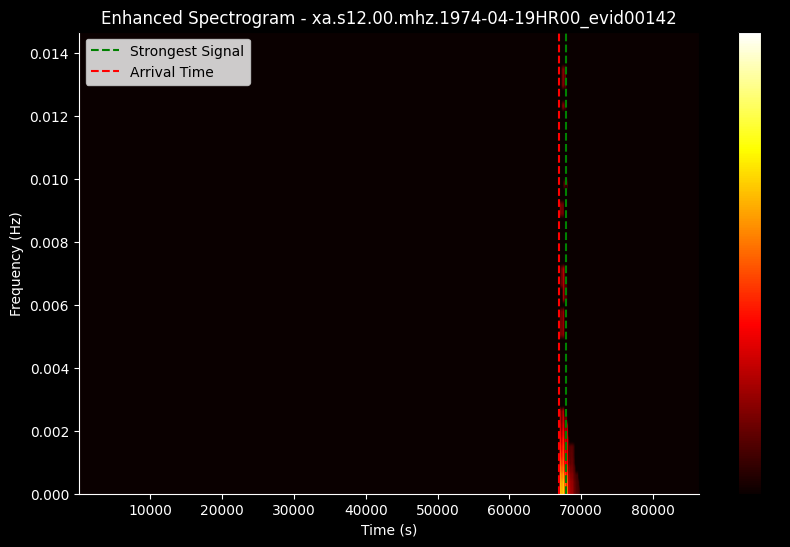

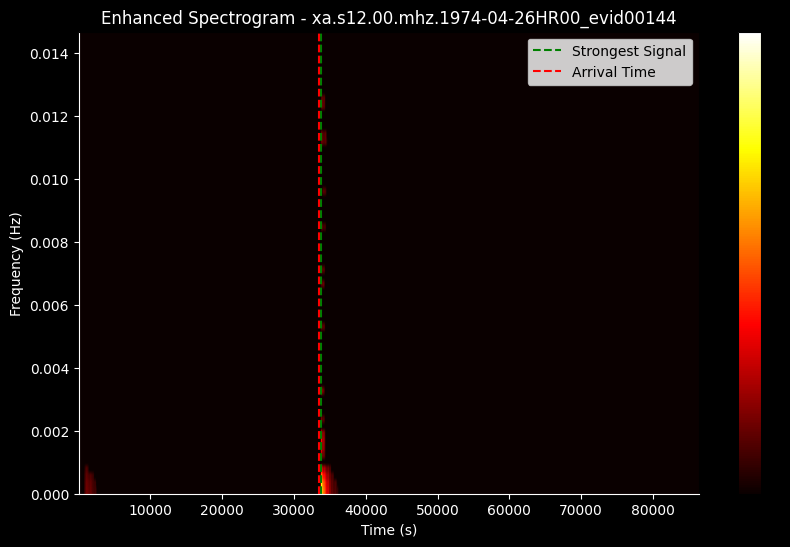

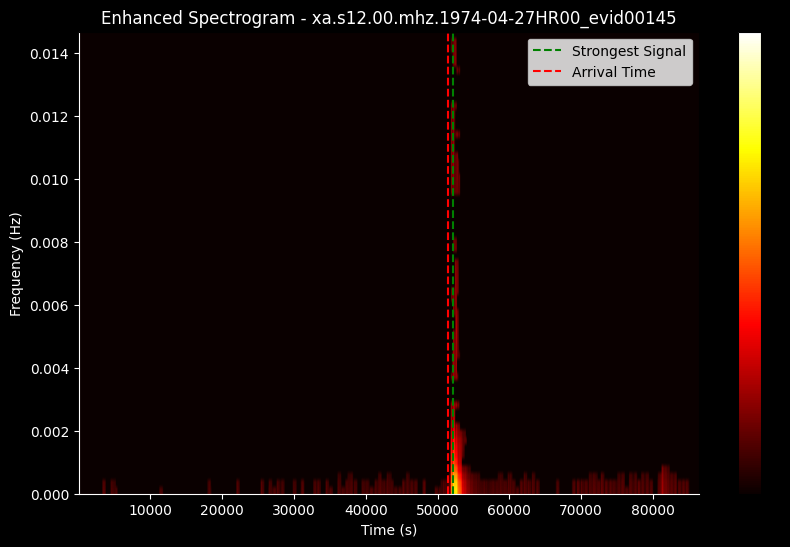

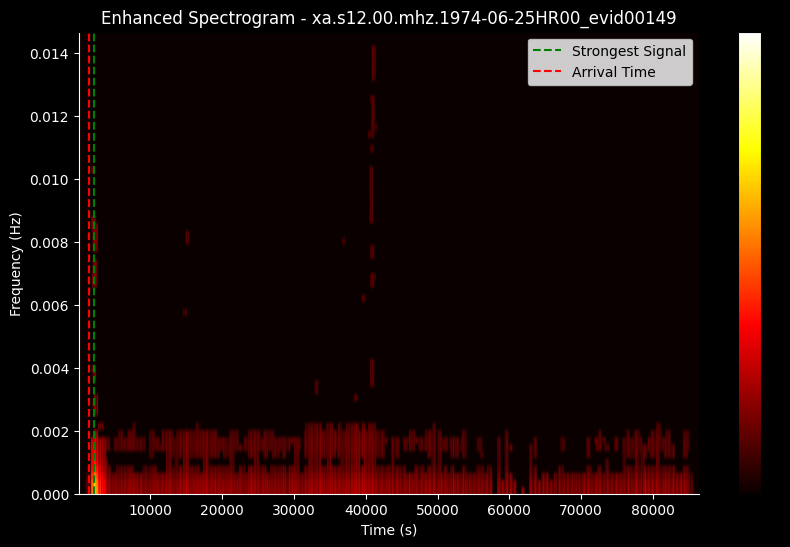

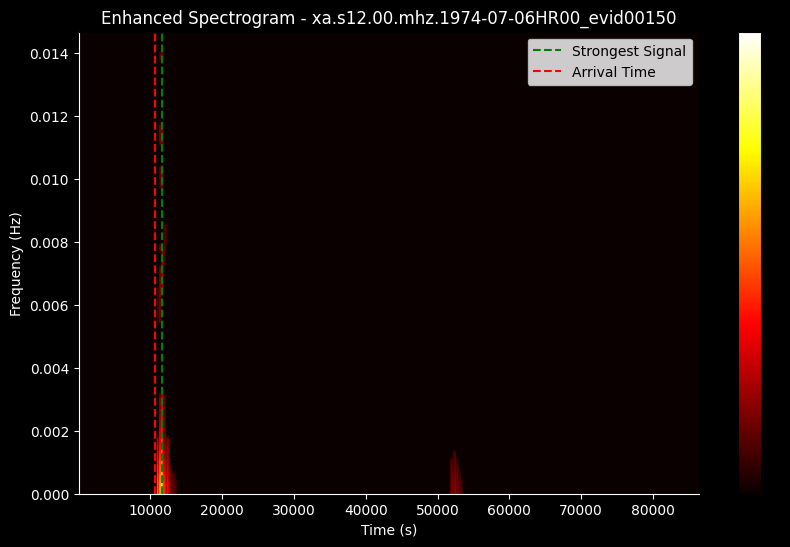

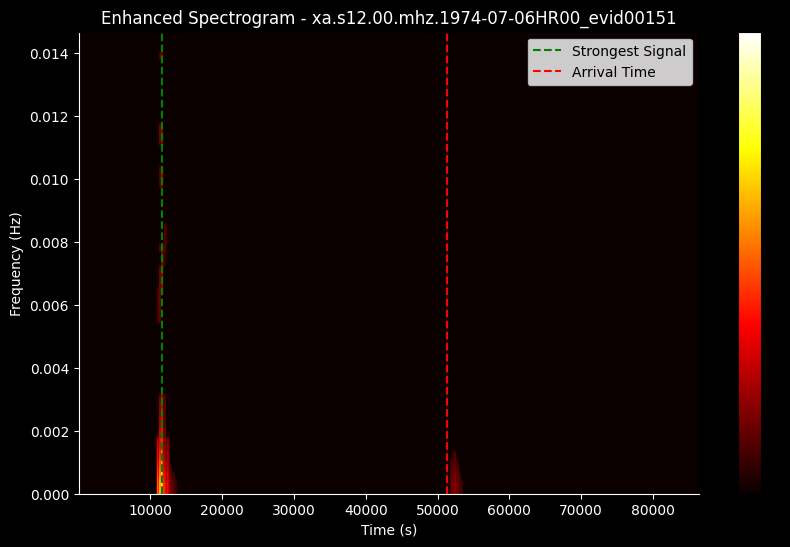

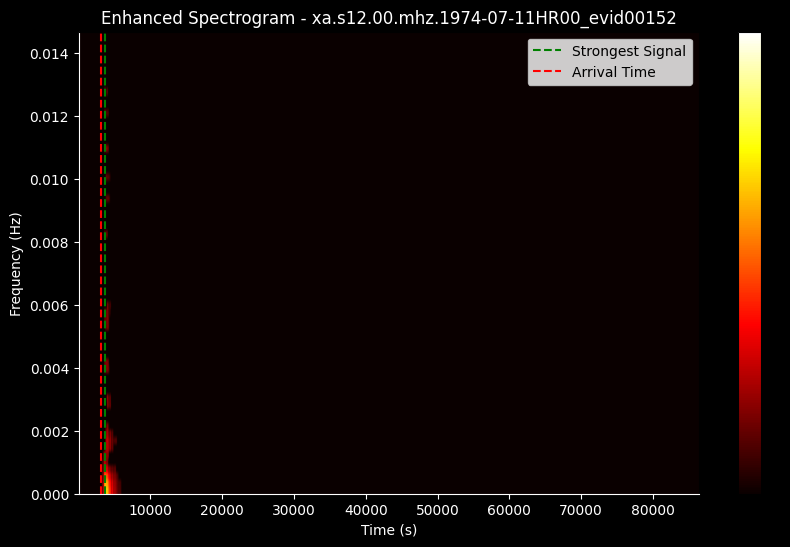

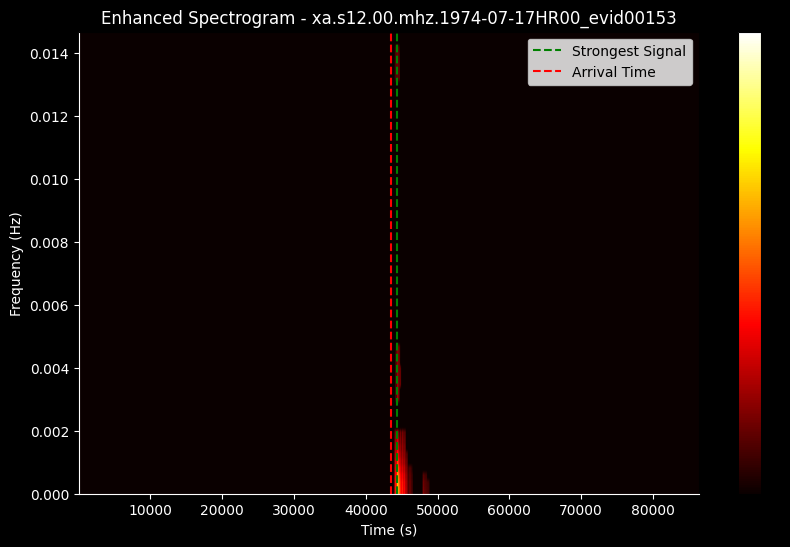

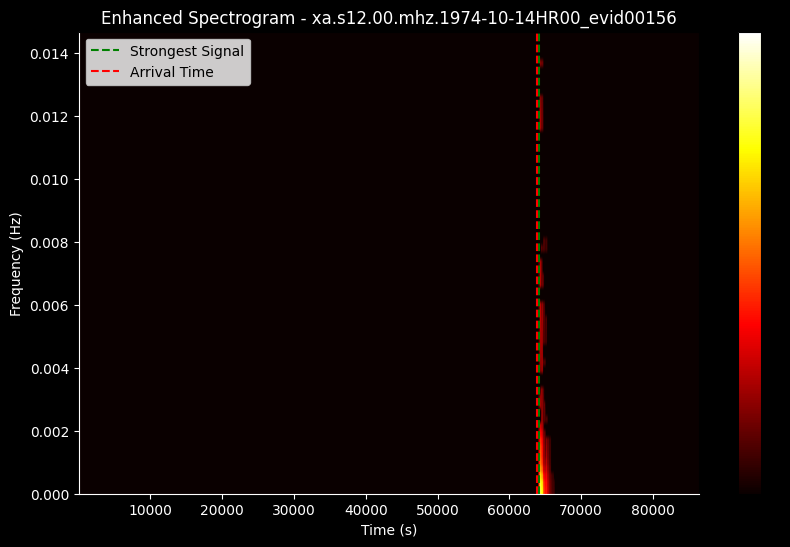

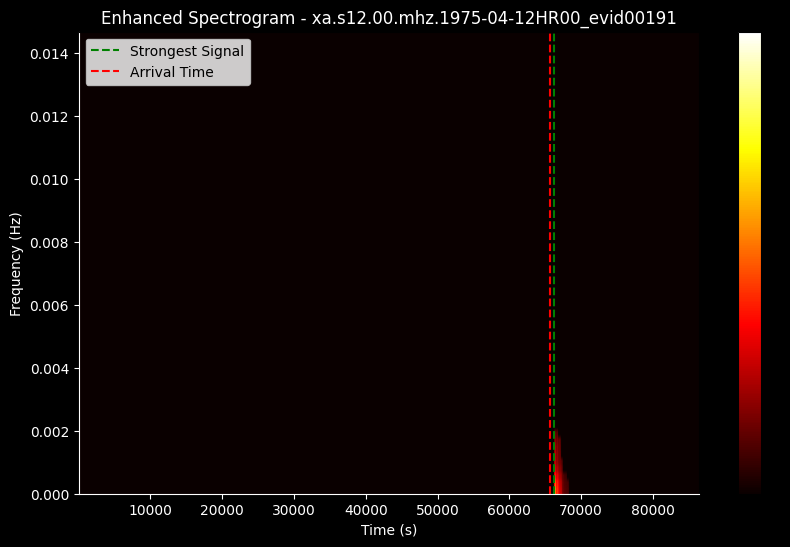

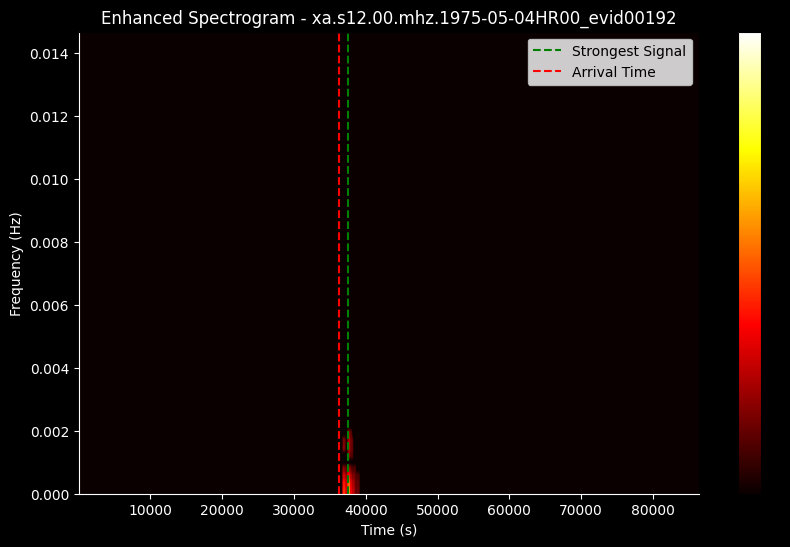

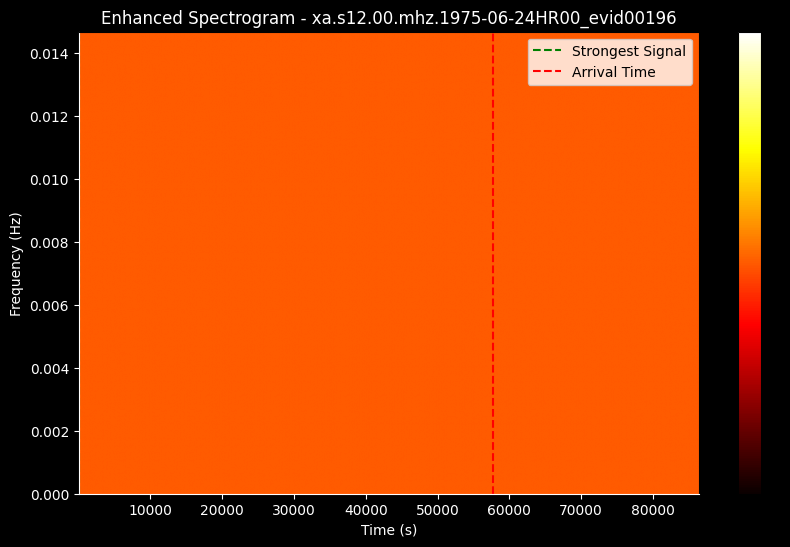

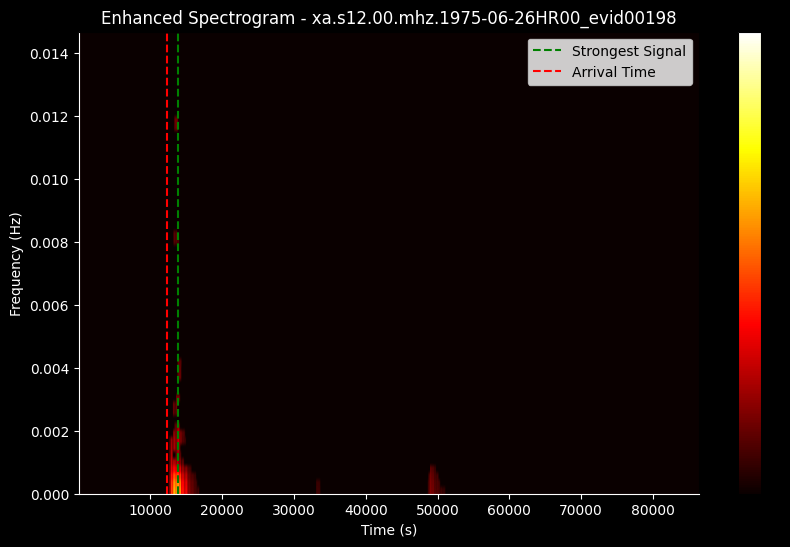

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
from datetime import datetime
import pandas as pd
from scipy import signal

cat_directory = './Server/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

max_relative_time = 86450
delta = 0.1509433962264151

nperseg = 64
noverlap = int(nperseg * 0.75)

spectrograms = []
arrival_times = []

threshold_value = 0.05
min_duration = 15

for i in range(len(cat)):
    row = cat.iloc[i]
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
    test_filename = row['filename']
    
    data_directory = './Server/data/lunar/training/data/S12_GradeA/'
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)

    tr = st.traces[0].copy()
    tr_data = tr.data

    minfreq = 0.3
    maxfreq = 1.5
    st.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)
    tr_filt = st.traces[0].copy()
    tr_data_filt = tr_filt.data

    f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)
    arrival_times.append((arrival_time - tr.stats.starttime.datetime).total_seconds())
    freqs_spectrogram = np.fft.rfftfreq(sxx.shape[0], d=(t[1] - t[0]))
    fft_spectrogram = np.fft.rfft(sxx, axis=0)

    fft_spectrogram_log = np.log1p(np.abs(fft_spectrogram))

    fft_spectrogram_norm = (fft_spectrogram_log - np.min(fft_spectrogram_log)) / (np.max(fft_spectrogram_log) - np.min(fft_spectrogram_log))

    fft_spectrogram_norm[fft_spectrogram_norm < threshold_value] = 0

    for freq_idx in range(fft_spectrogram_norm.shape[0]):
        strong_signal_times = np.where(fft_spectrogram_norm[freq_idx, :] > 0)[0]
        if len(strong_signal_times) > 0:
            signal_durations = np.split(strong_signal_times, np.where(np.diff(strong_signal_times) != 1)[0] + 1)
            for duration in signal_durations:
                if len(duration) < min_duration:
                    fft_spectrogram_norm[freq_idx, duration] = 0

    max_signal_idx = np.argmax(fft_spectrogram_norm)
    
    plt.figure(figsize=(10, 6), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    plt.imshow(fft_spectrogram_norm, aspect='auto', extent=[t[0], t[-1], freqs_spectrogram[0], freqs_spectrogram[-1]], origin='lower', cmap='hot')
    plt.colorbar(label='Log-Magnitude', ticks=[], orientation='vertical')
    
    plt.axvline(x=t[max_signal_idx], color='green', linestyle='--', label='Strongest Signal')
    
    plt.axvline(x=arrival_times[-1], color='red', linestyle='--', label='Arrival Time')

    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    plt.title(f'Enhanced Spectrogram - {test_filename}', color='white')
    plt.xlabel('Time (s)', color='white')
    plt.ylabel('Frequency (Hz)', color='white')
    plt.legend()
    plt.show()
